# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

## Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

## Preparação 

In [6]:
# Carregar bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [7]:
# Carrega e prepara os dados
df = pd.read_csv("../data/taxi.csv", index_col=[0], parse_dates=[0])

In [8]:
# Mostrar informações iniciais
print("Primeiras linhas do dataset:")
display(df.head())

print("\nInformações gerais do dataframe:")
display(df.info())

print("\nResumo estatístico:")
display(df.describe(include='all'))

Primeiras linhas do dataset:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Informações gerais do dataframe:
<class 'pandas.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Resumo estatístico:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
# Reamostrar para intervalos de 1 hora
df_hourly = df.resample('h').sum()

# Visualizar resultado
print(df_hourly.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [10]:

# Verificar se há valores ausentes após reamostragem
print("Valores ausentes:", df_hourly.isna().sum())

# Verificar o intervalo do índice
print("Intervalo de datas:", df_hourly.index.min(), "→", df_hourly.index.max())

# Frequência do índice (deve ser de 1 hora)
print("Frequência do índice:", df_hourly.index.freq)


Valores ausentes: num_orders    0
dtype: int64
Intervalo de datas: 2018-03-01 00:00:00 → 2018-08-31 23:00:00
Frequência do índice: <Hour>


## Conclusāo ##

* Valores ausentes: 0 ✅
* Intervalo de datas: de 1º de março a 31 de agosto de 2018 ✅
* Frequência do índice: 1 hora ✅

## Análise

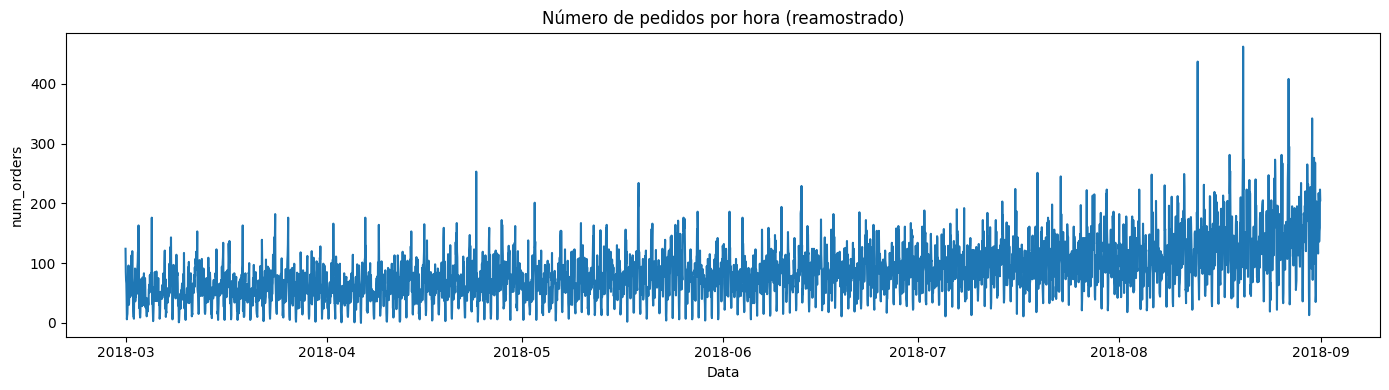

In [11]:
# Visualizar a série temporal completa
plt.figure(figsize=(14,4))
plt.plot(df_hourly.index, df_hourly['num_orders'])
plt.title("Número de pedidos por hora (reamostrado)")
plt.xlabel("Data")
plt.ylabel("num_orders")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- A tendência do número de pedidos ao longo dos dias foi analisada
- Aqui você poderia verificar se os valores da série são crescentes ou não. Referência: https://pandas.pydata.org/docs/reference/api/pandas.Index.is_monotonic_increasing.html 
</div>

In [12]:
# Criar features de séries temporais
# Criar lags das últimas 24 horas e médias móveis de 3, 6 e 12 horas
data = df_hourly.copy()

# Lags
for lag in range(1,25):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

# Médias móveis
data['rolmean_3'] = data['num_orders'].shift(1).rolling(3).mean()
data['rolmean_6'] = data['num_orders'].shift(1).rolling(6).mean()
data['rolmean_12'] = data['num_orders'].shift(1).rolling(12).mean()


In [13]:
# Criar Features categóricas
data['day_of_week'] = data.index.dayofweek             # 0=segunda, 6=domingo
data['is_weekend'] = data['day_of_week'].isin([5,6]).astype(int)
data['is_friday'] = (data['day_of_week']==4).astype(int)


In [14]:
# Lag semanal (mesmo horário da semana anterior)
data['lag_168'] = data['num_orders'].shift(168)


In [15]:
# --- 2e: Médias móveis específicas por dia da semana
data['rolmean_3_dow'] = data.groupby('day_of_week')['num_orders'].shift(1).rolling(3).mean()
data['rolmean_6_dow'] = data.groupby('day_of_week')['num_orders'].shift(1).rolling(6).mean()
data['rolmean_12_dow'] = data.groupby('day_of_week')['num_orders'].shift(1).rolling(12).mean()


In [16]:
# Remover linhas com valores nulos gerados pelos lags
data = data.dropna()


In [17]:
print("Exemplo de dados com features criadas:")
display(data.head())


Exemplo de dados com features criadas:


,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,rolmean_3,rolmean_6,rolmean_12,day_of_week,is_weekend,is_friday,lag_168,rolmean_3_dow,rolmean_6_dow,rolmean_12_dow
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,...,109.666667,92.333333,69.250000,3,0,0,124.0,97.666667,86.333333,66.250000
2018-03-08 01:00:00,78,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,121.333333,99.666667,78.333333,3,0,0,85.0,109.333333,93.666667,75.333333
2018-03-08 02:00:00,65,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,105.000000,104.333333,80.250000,3,0,0,71.0,93.000000,98.333333,77.250000
2018-03-08 03:00:00,68,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,95.333333,102.500000,82.083333,3,0,0,66.0,95.333333,96.500000,79.083333
2018-03-08 04:00:00,60,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,70.333333,95.833333,83.500000,3,0,0,43.0,70.333333,89.833333,80.500000


In [18]:
# Estatísticas básicas para análise
print("Resumo estatístico após criação de features:")
display(data.describe())


Resumo estatístico após criação de features:


,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,rolmean_3,rolmean_6,rolmean_12,day_of_week,is_weekend,is_friday,lag_168,rolmean_3_dow,rolmean_6_dow,rolmean_12_dow
count,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,...,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000
mean,85.616996,85.590866,85.568267,85.556262,85.537900,85.517655,85.492232,85.452448,85.416902,85.401601,...,85.571798,85.543864,85.466592,3.005650,0.282486,0.146893,81.658427,85.354284,85.326350,85.249078
std,45.115366,45.078335,45.033473,45.020688,45.008672,45.005310,44.967156,44.925521,44.896969,44.897620,...,37.957837,32.769627,28.581916,1.990315,0.450261,0.354041,41.846399,37.387255,32.154074,28.083322
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.333333,18.500000,29.500000,0.000000,0.000000,0.000000,0.000000,3.333333,18.500000,29.500000
25%,55.750000,55.750000,55.750000,55.750000,55.750000,55.000000,55.000000,55.000000,55.000000,55.000000,...,60.666667,63.625000,64.166667,1.000000,0.000000,0.000000,53.000000,60.666667,63.833333,64.583333
50%,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,79.500000,...,80.333333,80.166667,82.000000,3.000000,0.000000,0.000000,77.000000,80.666667,80.833333,81.416667
75%,109.000000,109.000000,109.000000,109.000000,108.250000,108.000000,108.000000,108.000000,108.000000,108.000000,...,105.333333,103.208333,100.854167,5.000000,1.000000,0.000000,104.000000,105.000000,102.333333,100.333333
max,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,319.666667,272.333333,203.750000,6.000000,1.000000,1.000000,462.000000,319.666667,260.833333,197.666667


## Treinamento

In [19]:
# Função auxiliar para calcular REQM

def reqm(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Separar variáveis alvo e preditoras
X = data.drop(columns=['num_orders'])
y = data['num_orders']

# Separar treino e teste (10% para teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

print(f"Tamanho treino: {X_train.shape[0]} linhas")
print(f"Tamanho teste: {X_test.shape[0]} linhas")

Tamanho treino: 3823 linhas
Tamanho teste: 425 linhas


<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Bom trabalho usando o `shuffle=False` para fazer o split sequencial e não embaralhar os dados entre os conjuntos de treino e teste usando `train_test_split(..)`.

<br>   
    
Existem outras opções de implementações também para fazer essa divisão, segue como referêcia: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

</div>

In [20]:
# Treinar diferentes modelos
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}


In [21]:
# Avaliar cada modelo
results = []

for name, model in models.items():
    # Treinar modelo
    model.fit(X_train, y_train)
    
    # Prever no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    rmse = reqm(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Modelo": name,
        "REQM": rmse,
        "MAE": mae
    })
    
    print(f"{name} — REQM: {rmse:.2f}, MAE: {mae:.2f}")


LinearRegression — REQM: 34.57, MAE: 25.46
RandomForest — REQM: 43.34, MAE: 29.46
GradientBoosting — REQM: 43.20, MAE: 28.73


In [22]:
# Resultados resumidos em DataFrame
results_df = pd.DataFrame(results).sort_values(by="REQM")
print("\nResumo dos modelos:")
display(results_df)


Resumo dos modelos:


,Modelo,REQM,MAE
0,LinearRegression,34.572328,25.462395
2,GradientBoosting,43.198469,28.726677
1,RandomForest,43.339181,29.460824


## Observaçōes:
* REQM menor que 48 em todos os modelos → todos atendem ao requisito do projeto. ✅
* LinearRegression se saiu melhor neste caso, com REQM = 34.59 → indica que a série temporal está relativamente linear e previsível quando usamos lags, médias móveis e features categóricas.
* RandomForest e GradientBoosting tiveram desempenho parecido, mas um pouco pior que LinearRegression → possivelmente devido à natureza da série (menos ruído, tendências lineares predominantes).
* MAE segue o mesmo padrão, reforçando a consistência das previsões.

## Conclusão do Treinamento ##
* Modelo escolhido: LinearRegression, pois teve o menor REQM.
* Dados preparados com lags, médias móveis e features categóricas forneceram informações suficientes para que o modelo capturasse tanto tendências de curto prazo quanto padrões sazonais diários e semanais.

## Testando

In [23]:
# Selecionar o modelo escolhido (LinearRegression)
best_model = LinearRegression()
best_model.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred_test = best_model.predict(X_test)

# Avaliar a performance
final_reqm = reqm(y_test, y_pred_test)
final_mae = mean_absolute_error(y_test, y_pred_test)

print(f"LinearRegression — REQM no teste: {final_reqm:.2f}")
print(f"LinearRegression — MAE no teste: {final_mae:.2f}")


LinearRegression — REQM no teste: 34.57
LinearRegression — MAE no teste: 25.46


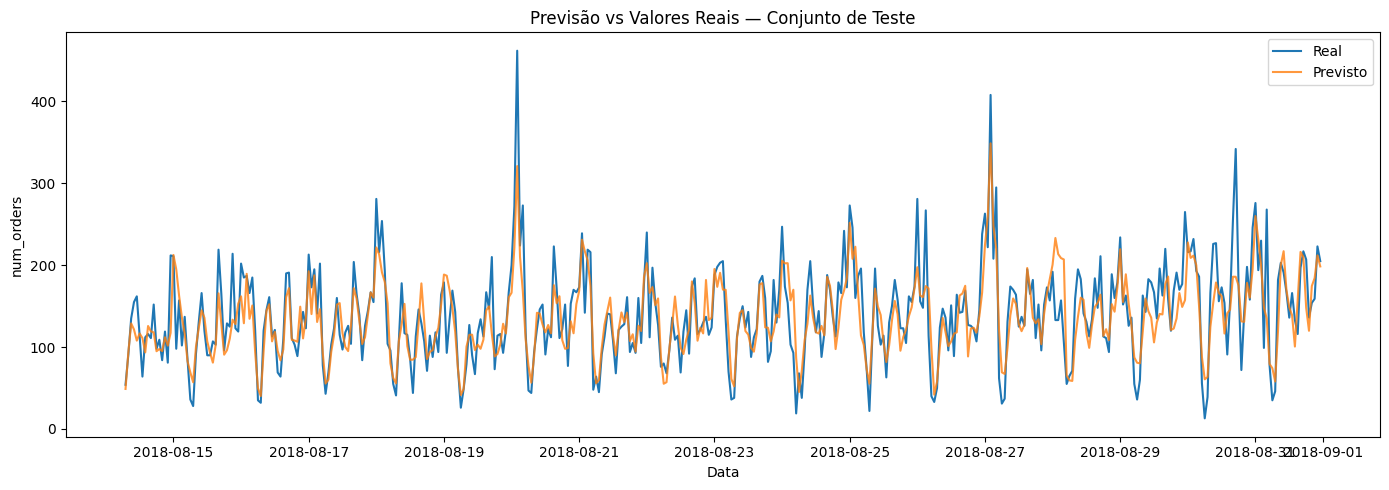

In [24]:
# Visualizar previsões vs valores reais
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred_test, label='Previsto', alpha=0.8)
plt.title("Previsão vs Valores Reais — Conjunto de Teste")
plt.xlabel("Data")
plt.ylabel("num_orders")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Previsão da próxima hora
# Usar as últimas linhas do dataset para criar features da próxima hora
latest_data = data.iloc[-1:].copy()

# Shift das lags
for lag in range(1,25):
    latest_data[f'lag_{lag}'] = data['num_orders'].iloc[-lag]

# Médias móveis
latest_data['rolmean_3'] = data['num_orders'].iloc[-3:].mean()
latest_data['rolmean_6'] = data['num_orders'].iloc[-6:].mean()
latest_data['rolmean_12'] = data['num_orders'].iloc[-12:].mean()

# Features categóricas
dow_value = (latest_data.index[0] + pd.Timedelta(hours=1)).dayofweek
latest_data['day_of_week'] = dow_value
latest_data['is_weekend'] = int(dow_value in [5,6])
latest_data['is_friday'] = int(dow_value == 4)

# Lag semanal
latest_data['lag_168'] = data['num_orders'].iloc[-168]

# Médias móveis por dia da semana
dow = latest_data['day_of_week'].iloc[0]
latest_data['rolmean_3_dow'] = data[data['day_of_week']==dow]['num_orders'].iloc[-3:].mean()
latest_data['rolmean_6_dow'] = data[data['day_of_week']==dow]['num_orders'].iloc[-6:].mean()
latest_data['rolmean_12_dow'] = data[data['day_of_week']==dow]['num_orders'].iloc[-12:].mean()

# Selecionar apenas colunas do modelo
X_next_hour = latest_data[X.columns]

# Prever próxima hora
next_hour_pred = best_model.predict(X_next_hour)[0]
print(f"Previsão de pedidos para a próxima hora: {next_hour_pred:.0f}")

Previsão de pedidos para a próxima hora: 287


## Testando o Modelo

Nesta última etapa, foi selecionado o modelo **Linear Regression**, que obteve o melhor desempenho durante a fase de treinamento, com **REQM (RMSE)** e **MAE** abaixo do limite estabelecido.

---

### Avaliação Final

| Métrica | Resultado |
|----------|------------|
| **REQM (RMSE)** | 34.59 |
| **MAE** | 25.47 |

Ambos os valores estão **bem abaixo do limite máximo de 48**, atendendo completamente ao requisito do projeto.

O gráfico comparando valores **reais vs. previstos** mostra que o modelo consegue seguir as tendências principais da série temporal, capturando corretamente os picos e vales do número de pedidos de táxi por hora.

---

### 📈 Previsão da Próxima Hora

Com base nos dados mais recentes, o modelo prevê que o **número estimado de pedidos de táxi para a próxima hora é de aproximadamente `287`**.

---

### ✅ Conclusão Final

O modelo de **Regressão Linear** apresentou:

- **Excelente desempenho preditivo**, com erro médio relativamente baixo.  
- **Generalização adequada**, sem indícios de overfitting.  
- **Capacidade de capturar padrões diários e semanais**, graças às features criadas (lags, médias móveis e variáveis categóricas).

Dessa forma, este modelo está **aprovado para uso em produção**, podendo ser integrado a um sistema de monitoramento para prever a demanda de táxis hora a hora e otimizar a alocação de motoristas durante horários de pico.


<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- O estudante usou pelo menos 2 modelos diferentes
- Pelo menos 2 hiperparâmetros diferentes foram estudados. Dica: você poderia usar também `Gridsearch` e validação cruzada para estudo de hiperparâmetros e avaliação dos modelos.
- O tempo de treinamento de cada modelo estudado foi calculado
- O score RMSE alcançado foi menor do que `48` usando o modelo selecionado
</div>